In [4]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf

In [3]:
# 讀檔
train_meta  = pd.read_csv("USER_META_train.csv")
test_meta = pd.read_csv("USER_META_test.csv")
train_time  = pd.read_csv("TIMEFLAG_train.csv")
test_time = pd.read_csv("TIMEFLAG_test.csv")

In [4]:
# 轉換出weekday的資訊
time_inf_to_add_train = np.empty([train_time.shape[0],1])
for i in range (train_time.shape[0]):
   time_inf_to_add_train[i,0]=datetime.date(train_time.loc[i][2],train_time.loc[i][3],train_time.loc[i][4]).weekday()
time_inf_to_add_test = np.empty([test_time.shape[0],1])
for i in range (test_time.shape[0]):
   time_inf_to_add_test[i,0]=datetime.date(test_time.loc[i][2],test_time.loc[i][3],test_time.loc[i][4]).weekday()
train_time_processed=pd.concat([train_time,pd.DataFrame(time_inf_to_add_train,columns=['weekday'])],axis=1)
test_time_processed=pd.concat([test_time,pd.DataFrame(time_inf_to_add_test,columns=['weekday'])],axis=1)

# 將想留下的資訊留下
train_x=pd.concat([train_meta[['uid', 'titlelen', 'deslen', 'tagcount', 'avgview', 'groupcount', 'avgmembercount']],train_time_processed[['year','month','day','hour_index','weekday']]],axis=1)
test_x=pd.concat([test_meta[['uid', 'titlelen', 'deslen', 'tagcount', 'avgview', 'groupcount', 'avgmembercount']],test_time_processed[['year','month','day','hour_index','weekday']]],axis=1)

# uid轉為數字以及做scalling
temp_x=pd.concat([train_x, test_x],axis=0)
temp_x.uid=pd.Categorical(temp_x.uid).codes
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(temp_x)

train_x_np=scaled_array[0:train_time.shape[0]][:]
test_x_np=scaled_array[train_time.shape[0]:scaled_array.shape[0]][:]

# 處存前處理後之檔案
pd.DataFrame(train_x_np).to_csv("train_x_np.csv",index=False)
pd.DataFrame(test_x_np).to_csv("test_x_np.csv",index=False)

In [5]:
# 讀取已經前處理好的檔案(因為前處理也很耗時，所以這邊再重複訓練的過程可以使用備份好的前處理檔案就好了)
train_x_np=pd.read_csv("train_x_np.csv")
test_x_np=pd.read_csv("test_x_np.csv")
train_y =pd.read_csv("LABELS_train.csv")
#y_max=train_y.logviews.max()
y_max=20
train_y=train_y.logviews/y_max

In [6]:
# 開始建神經網路

batch_size = 16384
epochs = 200

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1,l2

# 架構設計
model = Sequential()

model.add(Dense(2048, input_dim=12))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.4))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.4))


model.add(Dense(1))
model.add(Activation('relu'))

# 設定 optimizer
from keras.optimizers import  Adam
adam=Adam(lr=1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.008)
model.compile(loss='MAE', optimizer='Adam', metrics=['accuracy'])

# 設定 callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        print("loss:",logs.get('loss'))

loss_history = LossHistory()
checkpointer = ModelCheckpoint(filepath='record.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [7]:
# 開始訓練
history_adam = model.fit(train_x_np, train_y, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=True, validation_split=0.1, callbacks=[checkpointer, loss_history])

loss: 0.7684219
loss: 1.1194215
loss: 0.6154997
loss: 0.6253669
loss: 0.56485045
loss: 0.5346577
loss: 0.5230162
loss: 0.50328386
loss: 0.48149112
loss: 0.46822155
loss: 0.45748344
loss: 0.44741875
loss: 0.43630627
loss: 0.43103316
loss: 0.42040497
loss: 0.41095966
loss: 0.4061966
loss: 0.39763856
loss: 0.38917586
loss: 0.38222685
loss: 0.37540835
loss: 0.37413228
loss: 0.3691808
loss: 0.3689264
loss: 0.35964936
loss: 0.35352743
loss: 0.34612173
loss: 0.34447533
loss: 0.3403463
loss: 0.3347724
loss: 0.33447337
loss: 0.33517453
loss: 0.32423425
loss: 0.32296425
loss: 0.32002124
loss: 0.32208472
loss: 0.31024194
loss: 0.30996782
loss: 0.30418363
loss: 0.30448306
loss: 0.30457738
loss: 0.3023825
loss: 0.30205205
loss: 0.29359844
loss: 0.29416758
loss: 0.29458404
loss: 0.2897251
loss: 0.28909582
loss: 0.28766787
loss: 0.28773683
loss: 0.28131986
loss: 0.2812093
loss: 0.2793532
loss: 0.28134122
loss: 0.27650198
loss: 0.2735523
loss: 0.2726469
loss: 0.2742083
loss: 0.2699936
loss: 0.2671207


loss: 0.07607111
loss: 0.07521474
loss: 0.0754631
loss: 0.074934416
loss: 0.07507131
loss: 0.07534088
loss: 0.0751847
loss: 0.074733794
loss: 0.07494663
loss: 0.07464062
loss: 0.074331194
loss: 0.07411133
loss: 0.07409519
loss: 0.07394573
loss: 0.07313104
loss: 0.07381925
loss: 0.073045656
loss: 0.07220271
loss: 0.07275448
loss: 0.07285808
loss: 0.07292039
loss: 0.07252599
loss: 0.07208418
loss: 0.07213805
loss: 0.071866184
loss: 0.071591616
loss: 0.071654834
loss: 0.07205258
loss: 0.071473554
loss: 0.07154297
loss: 0.07098546
loss: 0.071496904
loss: 0.07169114
loss: 0.07104612
loss: 0.0716394
loss: 0.07168857
loss: 0.07100612
loss: 0.07074581
loss: 0.070739545
loss: 0.070770174
loss: 0.06970246
loss: 0.07018683
loss: 0.070191085
loss: 0.06982001
loss: 0.07024425
loss: 0.069908544
loss: 0.06937476
loss: 0.070988506
loss: 0.06945243
loss: 0.070926815
loss: 0.06991321
loss: 0.06972966
loss: 0.0700649
loss: 0.0695938
loss: 0.06957787
loss: 0.06873754
loss: 0.07049988
loss: 0.068815686
los

loss: 0.059846193
loss: 0.05960934
loss: 0.05964001
loss: 0.059914466
loss: 0.059670284
loss: 0.05953943
loss: 0.059703156
loss: 0.059975483
loss: 0.0600427
loss: 0.060240984
loss: 0.05973392
loss: 0.058634184
loss: 0.059637662
loss: 0.0597198
loss: 0.06004361
loss: 0.0596878
loss: 0.059424788
loss: 0.05994007
loss: 0.060487192
loss: 0.059421394
loss: 0.05952193
loss: 0.05910215
loss: 0.05887865
loss: 0.059325233
loss: 0.059939817
loss: 0.05926236
loss: 0.06009701
loss: 0.059307992
loss: 0.05958379
loss: 0.05984492
loss: 0.06027655
loss: 0.06012067
loss: 0.060033932
loss: 0.059690643
loss: 0.059274666
loss: 0.059144944
loss: 0.060001083
loss: 0.05921035
loss: 0.060023766
loss: 0.059347227
loss: 0.060199447
loss: 0.059488352
loss: 0.059667327
loss: 0.059035145
loss: 0.060231585
loss: 0.05936195
loss: 0.0587784
loss: 0.059273973
loss: 0.05907613
loss: 0.058885124
loss: 0.058669988
loss: 0.059419483
loss: 0.059976943
loss: 0.05998474
loss: 0.059341114
loss: 0.059673168
loss: 0.058862932
l

loss: 0.05804912
loss: 0.05861193
loss: 0.0580507
loss: 0.057737388
loss: 0.05862007
loss: 0.05719374
loss: 0.05804803
loss: 0.057201616
loss: 0.05800487
loss: 0.05742862
loss: 0.057679836
loss: 0.057504736
loss: 0.05754515
loss: 0.057149105
loss: 0.058037836
loss: 0.05809009
loss: 0.057959594
loss: 0.057317335
loss: 0.057822637
loss: 0.058156714
loss: 0.058428675
loss: 0.057004496
loss: 0.058143236
loss: 0.057382762
loss: 0.05914008
loss: 0.058516644
loss: 0.057729043
loss: 0.05673505
loss: 0.058451153
loss: 0.0577594
loss: 0.05790462
loss: 0.057776872
loss: 0.058047183
loss: 0.058128253
loss: 0.057981618
loss: 0.058060624
loss: 0.058126364
loss: 0.05774683
loss: 0.057428375
loss: 0.05788914
loss: 0.058377046
loss: 0.057451382
loss: 0.057314545
loss: 0.05842842
loss: 0.05782786
loss: 0.058556065
loss: 0.057293415
loss: 0.05888502
loss: 0.05735579
loss: 0.058025878
loss: 0.05779466
loss: 0.05831564
loss: 0.05762886
loss: 0.057073742
loss: 0.058289777
loss: 0.05730682
loss: 0.056709386


loss: 0.056567494
loss: 0.057462465
loss: 0.057487626
loss: 0.058087498
loss: 0.056236
loss: 0.056951195
loss: 0.05693902
loss: 0.056617267
loss: 0.056241572
loss: 0.057249863
loss: 0.057502106
loss: 0.056668967
loss: 0.05715566
loss: 0.056827143
loss: 0.057821378
loss: 0.056792777
loss: 0.056332998
loss: 0.056206636
loss: 0.056269377
loss: 0.05629262
loss: 0.05658935
loss: 0.05644476
loss: 0.05707482
loss: 0.056174625
loss: 0.0578145
loss: 0.056422055
loss: 0.05788722
loss: 0.057227746
loss: 0.05771352
loss: 0.056967884
loss: 0.057515193
loss: 0.056495782
loss: 0.057624854
loss: 0.0564764
loss: 0.057623312
loss: 0.057031043
loss: 0.05668366
loss: 0.057660364
loss: 0.05633018
loss: 0.057509173
loss: 0.0566268
loss: 0.056630515
loss: 0.05659464
loss: 0.05915844
loss: 0.056537546
loss: 0.057325475
loss: 0.056700878
loss: 0.056727663
loss: 0.055645246
loss: 0.056631837
loss: 0.05732263
loss: 0.05626809
loss: 0.056838326
loss: 0.057112806
loss: 0.05682338
loss: 0.056882013
loss: 0.05674409

loss: 0.055618465
loss: 0.056006547
loss: 0.055951457
loss: 0.055967912
loss: 0.056458928
loss: 0.055452798
loss: 0.056275804
loss: 0.05629254
loss: 0.055373736
loss: 0.055497922
loss: 0.055574574
loss: 0.055628285
loss: 0.055098586
loss: 0.05582202
loss: 0.05564935
loss: 0.05536613
loss: 0.05572141
loss: 0.055726852
loss: 0.05599129
loss: 0.055648435
loss: 0.05624624
loss: 0.05523609
loss: 0.055063464
loss: 0.05623368
loss: 0.055727445
loss: 0.055709604
loss: 0.05567833
loss: 0.056452446
loss: 0.05548752
loss: 0.056955434
loss: 0.055898666
loss: 0.055907104
loss: 0.055834904
loss: 0.056194372
loss: 0.056580294
loss: 0.0559019
loss: 0.05544414
loss: 0.056098323
loss: 0.05590949
loss: 0.0557331
loss: 0.05558915
loss: 0.055606253
loss: 0.05625668
loss: 0.05607666
loss: 0.055989683
loss: 0.05609713
loss: 0.056391124
loss: 0.05602317
loss: 0.056274496
loss: 0.05611831
loss: 0.056599215
loss: 0.056214057
loss: 0.055942226
loss: 0.05592213
loss: 0.056400836
loss: 0.05489168
loss: 0.05574726


loss: 0.055148706
loss: 0.055334028
loss: 0.05500354
loss: 0.055132363
loss: 0.055027645
loss: 0.055045404
loss: 0.05527015
loss: 0.055722
loss: 0.05528229
loss: 0.05545279
loss: 0.055396173
loss: 0.055177473
loss: 0.05535309
loss: 0.05501
loss: 0.055177085
loss: 0.054896615
loss: 0.055114157
loss: 0.05491095
loss: 0.056004476
loss: 0.05559799
loss: 0.055727452
loss: 0.0552559
loss: 0.055897467
loss: 0.0560543
loss: 0.054963827
loss: 0.054814234
loss: 0.05495829
loss: 0.055681847
loss: 0.05570416
loss: 0.055039503
loss: 0.055383824
loss: 0.05555076
loss: 0.055832
loss: 0.05568567
loss: 0.056122832
loss: 0.05586074
loss: 0.055437557
loss: 0.055107553
loss: 0.05533299
loss: 0.055083178
loss: 0.05492626
loss: 0.055481017
loss: 0.055504203
loss: 0.05516295
loss: 0.055483393
loss: 0.05439011
loss: 0.05506774
loss: 0.05533853
loss: 0.055583097
loss: 0.054942023
loss: 0.0553456
loss: 0.054838486
loss: 0.05552173
loss: 0.054663375
loss: 0.05586008
loss: 0.054888826
loss: 0.055246703
loss: 0.05

loss: 0.05452296
loss: 0.0548846
loss: 0.054749317
loss: 0.055009745
loss: 0.054335788
loss: 0.05470874
loss: 0.05484189
loss: 0.055105284
loss: 0.054825075
loss: 0.05417667
loss: 0.055189006
loss: 0.055325806
loss: 0.055039957
loss: 0.05488888
loss: 0.05434128
loss: 0.054580577
loss: 0.054975078
loss: 0.054516956
loss: 0.054441117
loss: 0.055684563
loss: 0.05536352
loss: 0.054988958
loss: 0.05475104
loss: 0.0543866
loss: 0.054892756
loss: 0.054921314
loss: 0.05486375
loss: 0.055902366
loss: 0.054451987
loss: 0.054978214
loss: 0.05458951
loss: 0.055307142
loss: 0.05482237
loss: 0.05463593
loss: 0.05415872
loss: 0.054668278
loss: 0.054835502
loss: 0.054142557
loss: 0.0553883
loss: 0.05431958
loss: 0.054839723
loss: 0.0541915
loss: 0.05426225
loss: 0.054417945
loss: 0.055180974
loss: 0.05467241
loss: 0.054384828
loss: 0.054810494
loss: 0.05450599
loss: 0.0542984
loss: 0.054912314
loss: 0.05408456
loss: 0.054530784
loss: 0.05456365
loss: 0.054700017
loss: 0.05474612
loss: 0.054954447
loss

loss: 0.05477396
loss: 0.054069117
loss: 0.054864258
loss: 0.05468866
loss: 0.054624118
loss: 0.054814853
loss: 0.05436693
loss: 0.053924862
loss: 0.055084325
loss: 0.054308847
loss: 0.053925946
loss: 0.054999128
loss: 0.053463306
loss: 0.05402259
loss: 0.054355204
loss: 0.054362148
loss: 0.05459369
loss: 0.053374834
loss: 0.054129064
loss: 0.053925857
loss: 0.054951288
loss: 0.05447454
loss: 0.054496307
loss: 0.05445283
loss: 0.053931825
loss: 0.05446238
loss: 0.054863002
loss: 0.05489602
loss: 0.054515697
loss: 0.053720236
loss: 0.055203035
loss: 0.054236963
loss: 0.05422531
loss: 0.054191813
loss: 0.053831648
loss: 0.052765086
loss: 0.053621262
loss: 0.054532256
loss: 0.05503644
loss: 0.053909227
loss: 0.05385849
loss: 0.05390012
loss: 0.05397301
loss: 0.054070048
loss: 0.054497894
loss: 0.054342743
loss: 0.054072574
loss: 0.054872498
loss: 0.054418143
loss: 0.054477517
loss: 0.05404128
loss: 0.05455345
loss: 0.05468981
loss: 0.0547728
loss: 0.0544358
loss: 0.054605357
loss: 0.05451

loss: 0.05422517
loss: 0.05424209
loss: 0.054110043
loss: 0.054162152
loss: 0.05454406
loss: 0.054044418
loss: 0.05400625
loss: 0.05394264
loss: 0.054014124
loss: 0.054255076
loss: 0.05423819
loss: 0.054478854
loss: 0.054107323
loss: 0.05414742
loss: 0.05385179
loss: 0.05381222
loss: 0.054227374
loss: 0.053260915
loss: 0.053774316
loss: 0.053806737
loss: 0.054675654
loss: 0.05425496
loss: 0.053780735
loss: 0.053925708
loss: 0.054316975
loss: 0.0543046
loss: 0.05338662
loss: 0.053933814
loss: 0.054102834
loss: 0.05373106
loss: 0.05440089
loss: 0.054226242
loss: 0.054476444
loss: 0.05431127
loss: 0.054811213
loss: 0.053372625
loss: 0.054016486
loss: 0.054103605
loss: 0.0531545
loss: 0.053575017
loss: 0.053757977
loss: 0.054126114
loss: 0.05406344
loss: 0.05532048
loss: 0.053747863
loss: 0.05393125
loss: 0.0537908
loss: 0.054336257
loss: 0.053743463
loss: 0.05401624
loss: 0.053642143
loss: 0.054172575
loss: 0.053811662
loss: 0.053554244
loss: 0.05454612
loss: 0.05440519
loss: 0.05332692
l

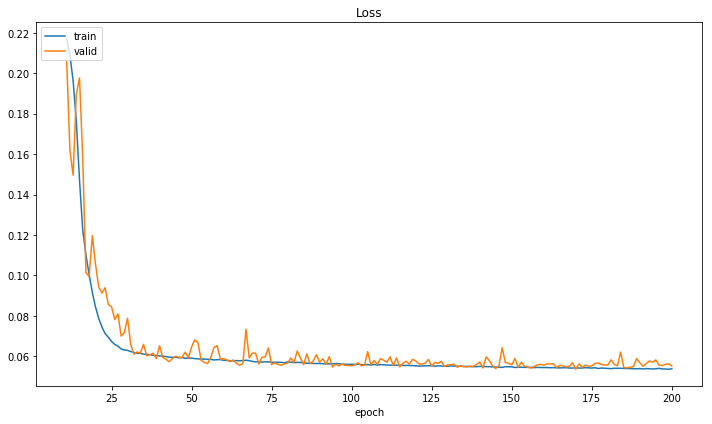

In [10]:
# 將訓練過程作圖以利分析
loss_adam= history_adam.history.get('loss')
val_loss_adam = history_adam.history.get('val_loss')
import matplotlib.pyplot as plt
plt.figure(0,figsize=(10,6))
plt.plot(list(range(11,epochs+1)), loss_adam[10:len(loss_adam)],label='train')
plt.plot(list(range(11,epochs+1)), val_loss_adam[10:len(val_loss_adam)],label='valid')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('optimizerSelection.png',dpi=100,format='png')
plt.show()
plt.close()

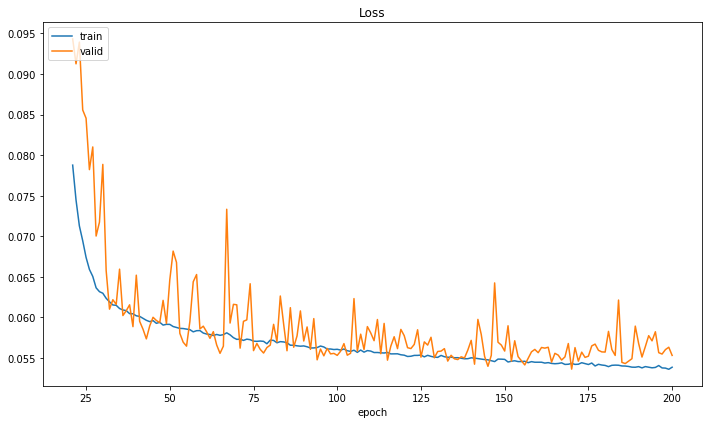

In [11]:
# 將訓練過程作圖以利分析
loss_adam= history_adam.history.get('loss')
val_loss_adam = history_adam.history.get('val_loss')
import matplotlib.pyplot as plt
plt.figure(0,figsize=(10,6))
plt.plot(list(range(21,epochs+1)), loss_adam[20:len(loss_adam)],label='train')
plt.plot(list(range(21,epochs+1)), val_loss_adam[20:len(val_loss_adam)],label='valid')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('optimizerSelection.png',dpi=100,format='png')
plt.show()
plt.close()

In [12]:
# 輸出test預設檔案
test_y=model.predict(test_x_np, batch_size=None, verbose=0, steps=None)
test_y=test_y*y_max
test_meta = pd.read_csv("USER_META_test.csv")
output=pd.concat([test_meta[['pid','uid']],pd.DataFrame(test_y,columns=['logviews'])],axis=1);
output.to_csv("upload.csv",index=False)